# Experiment: SML2010 Dataset

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
import seaborn as sns

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

df1=pd.read_csv('SML2010data-1.txt',sep = ' ')
df2=pd.read_csv('SML2010data-2.txt',sep = ' ')
tt=len(df1)
df=pd.concat([df1,df2],ignore_index=True)
df=df.drop(columns=['1:Date','2:Time','3:Temperature_Comedor_Sensor','5:Weather_Temperature','19:Exterior_Entalpic_1','20:Exterior_Entalpic_2','21:Exterior_Entalpic_turbo','24:Day_Of_Week']) 
df.head()

,4:Temperature_Habitacion_Sensor,6:CO2_Comedor_Sensor,7:CO2_Habitacion_Sensor,8:Humedad_Comedor_Sensor,9:Humedad_Habitacion_Sensor,10:Lighting_Comedor_Sensor,11:Lighting_Habitacion_Sensor,12:Precipitacion,13:Meteo_Exterior_Crepusculo,14:Meteo_Exterior_Viento,15:Meteo_Exterior_Sol_Oest,16:Meteo_Exterior_Sol_Est,17:Meteo_Exterior_Sol_Sud,18:Meteo_Exterior_Piranometro,22:Temperature_Exterior_Sensor,23:Humedad_Exterior_Sensor
0,17.8275,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,18.1150,48.3750
1,18.1207,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,18.4147,47.8080
2,18.4367,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,18.8533,47.4320
3,18.7513,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,19.2907,47.0240
4,19.0414,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,19.7400,45.4743


In [128]:
x=df.iloc[:,1:]
y=df.iloc[:,0]
x=preprocessing.StandardScaler().fit(x).transform(x) #normalize
x=pd.DataFrame(x)
y=pd.DataFrame(y)
data=pd.concat([y,x],axis=1)

train,calibration=train_test_split(data[:tt],test_size=0.5, random_state=1)
test=data[tt:]
train_y = train.iloc[:,0]
train_x = train.iloc[:,1:]
calibration_y = calibration.iloc[:,0]
calibration_x = calibration.iloc[:,1:]
test_y = test.iloc[:,0]
test_x = test.iloc[:,1:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x.shape,calibration_x.shape,test_x.shape

((1382, 15), (1382, 15), (1373, 15))

In [129]:
train_x=train_x.to_numpy()
train_y=train_y.to_numpy()
calibration_x=calibration_x.to_numpy()
calibration_y=calibration_y.to_numpy()
test_x=test_x.to_numpy()
test_y=test_y.to_numpy()

In [130]:
nntrain_x = torch.from_numpy(train_x).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y).float()) 
nntest_x= torch.from_numpy(test_x).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

### Random Feature

In [131]:
def sample_1d(pdf, gamma):
    if pdf=='G':
        w=torch.randn(1)*gamma
        return w
    elif pdf=='L':
        w=torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    elif pdf=='C':
        w=torch.distributions.cauchy.Cauchy(torch.tensor([0.0]), torch.tensor([1.0])).sample()*gamma
        return w
    
def sample(pdf, gamma, d):
    return torch.tensor([sample_1d(pdf, gamma) for _ in range(d)])

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = torch.rand(self.D)*2*torch.pi
        self.W = sample(self.kernel, self.gamma, self.d*self.D).reshape(self.D,self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       
        result=torch.sqrt(torch.tensor([2.0/self.D])) * torch.cos( self.W @ x.T  + (self.b.reshape(-1,1) @ torch.ones(len(x)).reshape(1,-1))) 
        #print(result.T.shape)
        return result.T

In [264]:
total_x=np.vstack((train_x,calibration_x))
total_y=np.hstack((train_y,calibration_y))
### RF
t0=time.time()
model=Ridge()
param_grid = {
    'alpha': [1e-4,1e-3,1e-2,1e-1,1]
}
rff=RandomFourierFeature(15,500,kernel='G',gamma=0.4)
total_feature=rff.transform(total_x)
test_feature=rff.transform(test_x)

kf = KFold(n_splits=5, shuffle=True)  
grid_search = GridSearchCV(model, param_grid, cv=kf)
grid_search.fit(total_feature, total_y)

print("Best parameters found: ", grid_search.best_params_)

best_model = grid_search.best_estimator_
rf_pred = best_model.predict(test_feature)
rf_pred_total = best_model.predict(total_feature)

t1=time.time()-t0
print("Train error: ",mean_squared_error(total_y,rf_pred_total))
print("Test error: ",mean_squared_error(test_y,rf_pred))
print("Time:",t1)

Best parameters found:  {'alpha': 0.01}
Train error:  0.12156166720760167
Test error:  3.958353689627201
Time: 0.8615560531616211


## 1. DNN

In [204]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=256, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=256, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(15, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 1e-3}],lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=300) 
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    #scheduler.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    dnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    dnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>50 and float(dnn_trainloss[-1])>max(dnn_trainloss[-50:-1]):
        break
    
    if epoch % 50 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {dnn_trainloss[-1]}
            Test  set - loss: {dnn_testloss[-1]}
            ''')
    
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=15, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 268.2739927868501
            Test  set - loss: 413.18251178136643
            
epoch 50
            Train set - loss: 1.6849694374953974
            Test  set - loss: 4.367058053679177
            
epoch 100
            Train set - loss: 1.0275204770441801
            Test  set - loss: 3.0066690748953757
            
epoch 150
            Train set - loss: 0.790933696398655
            Test  set - loss: 2.517032054305896
            
epoch 200
            Train set - loss: 0.6808428887338424
            Test  set - loss: 2.300408087078131
            
epoch 250
            Train set - loss: 0.6136289447252554
            Test  set - loss: 2.1419293656924667
            
epoch 300
            Train set - loss: 0.568331392216045
            Test  set - loss: 2.0533

## 2. Resnet

In [156]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=256, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=256, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(15,100)
        self.rblock2 = ResidualBlock(100,50)
        self.fc3 = nn.Linear(50,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 5e-4}],lr=5e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=200) 
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(1000):
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    #scheduler.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    res_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    res_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>50 and float(res_trainloss[-1])>max(res_trainloss[-50:-1]):
        break
    
    if epoch % 50 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {res_trainloss[-1]}
            Test  set - loss: {res_testloss[-1]}
            ''')
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=15, out_features=100, bias=True)
    (fc2): Linear(in_features=15, out_features=100, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (fc2): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 355.03191302154727
            Test  set - loss: 518.664142641382
            
epoch 50
            Train set - loss: 1.213943989720693
            Test  set - loss: 4.901201104127658
            
epoch 100
            Train set - loss: 0.7430988044265183
            Test  set - loss: 3.2646995938487833
            
epoch 150
            Train set - loss: 0.5848382184437432
            Test  set - loss: 2.719669732535226
            
epoch 200
            Train set - loss: 0.5041035811452544
            Test  set - loss: 2.316316776317526
            
epoch 250
         

## 3. MLKM

In [248]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=256, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=256, shuffle=False)

rff1=RandomFourierFeature(15,100,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(50,50,kernel='G',gamma=0.4)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(100, 50)
        self.fc2 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = rff1.transform(x)
        x=self.fc1(x)
        x = rff2.transform(x)
        return self.fc2(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=7e-4,momentum=0.95,weight_decay=1e-3) #optim.Adam(...)
#optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 1e-3}],lr=1e-3,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=200) 
loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    #scheduler.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    kernelnn_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    kernelnn_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>50 and float(kernelnn_trainloss[-1])>max(kernelnn_trainloss[-50:-1]):
        break
    
    if epoch % 50 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {kernelnn_trainloss[-1]}
            Test  set - loss: {kernelnn_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 325.07944058422504
            Test  set - loss: 481.7719194421836
            
epoch 50
            Train set - loss: 1.3344233060848651
            Test  set - loss: 4.555308217976122
            
epoch 100
            Train set - loss: 0.7734409798946843
            Test  set - loss: 2.8517990591308133
            
epoch 150
            Train set - loss: 0.6356515784520463
            Test  set - loss: 2.209214378085125
            
epoch 200
            Train set - loss: 0.5685256393750052
            Test  set - loss: 2.003443821296363
            
epoch 250
            Train set - loss: 0.5251863428766363
            Test  set - loss: 1.8471099919739018
            
epoch 300
            Train set - loss: 0.4970798883988213
            Test  set - loss: 1.6720000364368133
            
epoch 350
            Train

In [249]:
##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1))])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
    pred_xall.append(test_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(test_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 1373/1373 [00:06<00:00, 198.03it/s]

length 7.607590601256449
95 coverage 0.8938356164383562


## 4. Residual multilayer learning

In [168]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=128, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=128, shuffle=False)

rff0=RandomFourierFeature(15,100,kernel='G',gamma=0.1)
rff1=RandomFourierFeature(50,50,kernel='G',gamma=0.4)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(100,50,rff1)
        self.fc2 =nn.Linear(50,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        return self.fc2(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=-0.1,b=0.1)
        m.bias.data.fill_(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#optimizer=optim.SGD([{'params': net.parameters(), 'initial_lr': 1e-4}],lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100,gamma=0.5,last_epoch=200) 


loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(1000): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    #scheduler.step()
    
    x0=torch.from_numpy(train_x[:]).float()
    with torch.no_grad():
        x0 = x0.to(device)
        pred = net(x0)
    reskernel_trainloss.append(mean_squared_error(pred,train_y))
    
    x1=torch.from_numpy(test_x[:]).float()
    with torch.no_grad():
        x1 = x1.to(device)
        pred = net(x1)
    reskernel_testloss.append(mean_squared_error(pred,test_y))
    
    if epoch>50 and float(reskernel_trainloss[-1])>max(reskernel_trainloss[-50:-1]):
        break
    
    if epoch % 50 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {reskernel_trainloss[-1]}
            Test  set - loss: {reskernel_testloss[-1]}
            ''')
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=100, out_features=50, bias=True)
    (fc2): Linear(in_features=50, out_features=50, bias=True)
  )
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 344.94020094665035
            Test  set - loss: 506.5367079780111
            
epoch 50
            Train set - loss: 6.992483005591011
            Test  set - loss: 19.59318915610683
            
epoch 100
            Train set - loss: 4.485185040270061
            Test  set - loss: 11.879596403513512
            
epoch 150
            Train set - loss: 2.613701958048122
            Test  set - loss: 6.40124359833539
            
epoch 200
            Train set - loss: 1.7904402958805319
            Test  set - loss: 4.538404059172468
            
epoch 250
            Train set - loss: 1.3374637253585586
            Test  set - loss: 3.5301856589122327
            
epoch 300
            Train set - loss: 1.05370513750

In [169]:
##conformal prediction
#predict

coverage=0
par=optimizer.param_groups[0]['params']
for i in tqdm(range(len(train_x))):
    x0=torch.from_numpy(train_x[i:1+i]).float()
    x0 = x0.to(device)
    pred = net(x0)
    fi=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()   
    for j in range(len(par)): 
        fi=torch.cat([fi,par[j].grad.reshape(-1)])
    fi=fi.reshape(1,-1)
    if i==0:
        Fi=fi
    else:
        Fi=torch.cat([Fi,fi])   
temp=torch.linalg.inv(Fi.T @ Fi)

mark=0
score=torch.tensor([])
for i in tqdm(range(len(calibration_x))):
    x0=torch.from_numpy(calibration_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)
    fFFf=f0.T @ temp @ f0
    if fFFf < 0:
        continue
    score=torch.cat([score,np.abs(pred.detach().numpy()[0][0]-calibration_y[i])/(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1))])
    mark=mark+1
score=score.reshape(-1)
sorted_score, sorted_indices=torch.sort(score)
q=(len(score)+1)*0.95
a=sorted_score[int(np.ceil(q))]

pred_xall=[]
pred_yall=[]
true_yall=[]
dist=[]
mark=0
length=[]
for i in tqdm(range(len(test_x))):
    x0=torch.from_numpy(test_x[i:i+1]).float()
    x0 = x0.to(device)
    pred = net(x0)
    par=optimizer.param_groups[0]['params']
    f0=torch.tensor([])
    for j in range(len(par)):
        par[j].grad.data.zero_()
    pred.backward()
    for j in range(len(par)):
        f0=torch.cat([f0,par[j].grad.reshape(-1)])
    f0=f0.reshape(-1,1)

    fFFf=f0.T @ temp @ f0
    
    if fFFf < 0:
        continue
    mark=mark+1
    dd=(np.sqrt(kernelnn_trainloss[-1])*np.sqrt(fFFf+1)*a).detach().numpy()[0][0]
    length.append(2*dd)
    
    #coverage
    if pred.detach().numpy()[0][0]-dd<test_y[i] and pred.detach().numpy()[0][0]+dd>test_y[i]:
        coverage=coverage+1
    pred_xall.append(test_x[i][0])
    pred_yall.append(pred.detach().numpy()[0][0])
    true_yall.append(test_y[i])
    dist.append(dd)
coverage=coverage/mark


print("length",np.mean(length))
print("95 coverage",coverage)

100%|██████████| 1373/1373 [00:15<00:00, 86.35it/s]

length 6.232842354690982
95 coverage 0.9153696498054474


comparison

In [250]:
def plot_choose(fig,start,data,linestyle="-"):
    fig.plot(np.arange(start,len(data)),data[start:],linestyle=linestyle)

0.3732516422578559 0.24013283575503816 0.3858978683462085 0.4971735983302475
1.6926738206678191 1.5536217603817064 1.5179111467488886 1.346961868814673


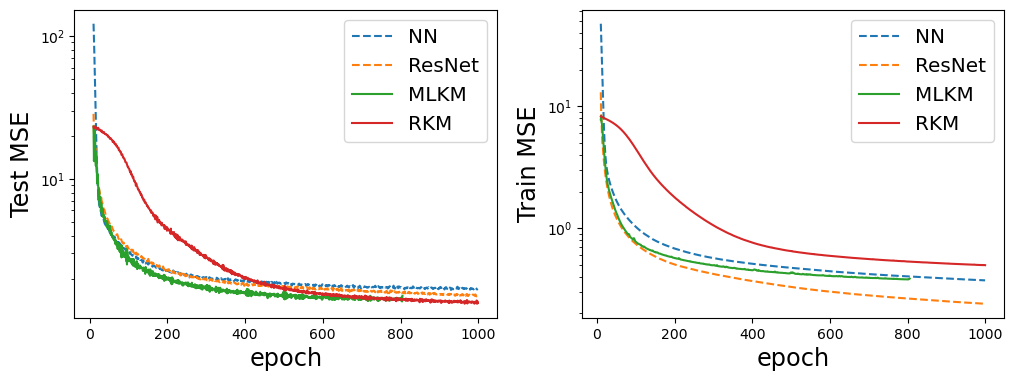

In [254]:
print(dnn_trainloss[-1],res_trainloss[-1],kernelnn_trainloss[-1],reskernel_trainloss[-1])
print(dnn_testloss[-1],res_testloss[-1],kernelnn_testloss[-1],reskernel_testloss[-1])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_choose(ax[0],10,dnn_testloss,linestyle="--")
plot_choose(ax[0],10,res_testloss,linestyle="--")
plot_choose(ax[0],10,kernelnn_testloss)
plot_choose(ax[0],10,reskernel_testloss)
ax[0].legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[0].set_xlabel("epoch",fontsize="xx-large")
ax[0].set_ylabel("Test MSE",fontsize="xx-large")
ax[0].set_yscale('log')

plot_choose(ax[1],10,dnn_trainloss,linestyle="--")
plot_choose(ax[1],10,res_trainloss,linestyle="--")
plot_choose(ax[1],10,kernelnn_trainloss)
plot_choose(ax[1],10,reskernel_trainloss)
ax[1].legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
ax[1].set_xlabel("epoch",fontsize="xx-large")
ax[1].set_ylabel("Train MSE",fontsize="xx-large")
ax[1].set_yscale('log')
plt.show()

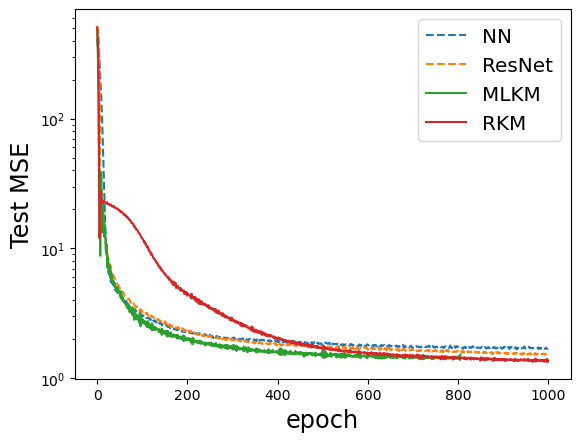

In [253]:
plt.plot(dnn_testloss,linestyle="--")
plt.plot(res_testloss,linestyle="--")
plt.plot(kernelnn_testloss)
plt.plot(reskernel_testloss)
plt.legend(["NN","ResNet","MLKM","RKM"],fontsize="x-large")
plt.xlabel("epoch",fontsize="xx-large")
plt.ylabel("Test MSE",fontsize="xx-large")
plt.yscale('log')
plt.show()